In [1]:
import pandas as pd
import numpy as np

## Load mail chimp data

In [98]:
csv_path = '/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/mailchimp/members_export_21_march_2016.csv'
mail = pd.read_csv(csv_path)

In [99]:
mail['CONFIRM_TIME'] = pd.to_datetime(mail['CONFIRM_TIME'])

In [100]:
first_email = min(mail['CONFIRM_TIME'])

In [101]:
mail = mail.drop(mail.columns[1:], axis=1)

In [102]:
mail['mail_chimp'] = 1

In [103]:
mail.columns = ['email', 'mail_chimp']

## Load paypal data

In [104]:
import os

In [105]:
csv_dir = '/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/paypal/'
csv_files = [os.path.join(csv_dir, x) for x in os.listdir(csv_dir)]

In [106]:
csv_files

['/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/paypal/paypal_2010_2012.csv',
 '/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/paypal/paypal_2012_2014.csv',
 '/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/paypal/paypal_2014_2016.csv']

In [107]:
paypal = pd.concat((pd.read_csv(f) for f in csv_files))

In [108]:
paypal.columns = [x.strip() for x in paypal.columns]

In [109]:
paypal['Date'] = pd.to_datetime(paypal['Date'])

In [110]:
first_sample = min(paypal['Date'])

### Keep only sample purchases

In [111]:
paypal = paypal.loc[paypal['Item Title'] == 'Hardwood Flooring Samples', :]

In [112]:
paypal = pd.DataFrame(paypal['From Email Address'])

In [113]:
paypal = paypal.drop_duplicates()

In [114]:
paypal['samples'] = 1

In [115]:
paypal.columns = ['email', 'samples']

## Load MySQL Data

In [61]:
import bd_mysql

In [62]:
config_path = '/Users/lindsay/Documents/Data Science/BrazilianDirect/cfg/mysql.cfg'
con = bd_mysql.connect_bd_mysql(config_path)
df = bd_mysql.download_quote_data(con)
df = bd_mysql.pre_process_mysql(df)

In [68]:
df.columns

Index([u'quote_id', u'email', u'date_created', u'days_until_needed',
       u'phone_provided', u'ship_state', u'install_subfloor', u'employee_id',
       u'sq_ft', u'cust_price', u'retail_price', u'common_name', u'finish',
       u'grade', u'milling', u'width', u'construction',
       u'days_until_needed_bin', u'sq_ft_bin', u'converted', u'month',
       u'year'],
      dtype='object')

## Join MySQL, mail chimp, and paypal

In [69]:
df_all = pd.merge(df, mail, how='left', on='email')

In [71]:
df_all['mail_chimp'].value_counts(dropna=False)

NaN     26862
 1.0    12459
Name: mail_chimp, dtype: int64

In [72]:
df_all = pd.merge(df_all, paypal, how='left', on='email')

In [73]:
df_all['samples'].value_counts(dropna=False)

NaN     37431
 1.0     1890
Name: samples, dtype: int64

In [74]:
# Replace nan with 0
df_all['mail_chimp'] = df_all['mail_chimp'].fillna(value=0)
df_all['samples'] = df_all['samples'].fillna(value=0)

## Filter quotes before samples/mailchimp

In [125]:
earliest_date = pd.datetime.date(max(first_email, first_sample))
earliest_date

datetime.date(2011, 7, 15)

In [130]:
df_all = df_all.loc[df_all['date_created'] >= earliest_date, :]

In [131]:
df_all.shape

(21673, 24)

## Crosstabs

In [150]:
from scipy.stats import chisquare

In [147]:
xt_samples_converted = pd.crosstab(df_all['samples'], df_all['converted'])
xt_samples_converted = xt_samples_converted.reset_index()
xt_samples_converted.columns = ['samples', 'no_purchase', 'purchase']
xt_samples_converted['total'] = xt_samples_converted['no_purchase'] + xt_samples_converted['purchase']
xt_samples_converted['percent'] = xt_samples_converted['purchase'] / xt_samples_converted['total'] * 100
xt_samples_converted

,samples,no_purchase,purchase,total,percent
0,0.0,18663,1203,19866,6.055572
1,1.0,1465,342,1807,18.926397


In [153]:
# chisquare test
f_exp = xt_samples_converted.loc[0, ['no_purchase', 'purchase']].values
f_obs = xt_samples_converted.loc[1, ['no_purchase', 'purchase']].values

chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=16464.225861029259, pvalue=0.0)

In [149]:
xt_mail_converted = pd.crosstab(df_all['mail_chimp'], df_all['converted']).reset_index()
xt_mail_converted.columns = ['mail_chimp', 'no_purchase', 'purchase']
xt_mail_converted['total'] = xt_mail_converted['no_purchase'] + xt_mail_converted['purchase']
xt_mail_converted['percent'] = xt_mail_converted['purchase'] / xt_mail_converted['total'] * 100
xt_mail_converted

,mail_chimp,no_purchase,purchase,total,percent
0,0.0,9912,617,10529,5.860006
1,1.0,10216,928,11144,8.327351


In [154]:
# chisquare test
f_exp = xt_mail_converted.loc[0, ['no_purchase', 'purchase']].values
f_obs = xt_mail_converted.loc[1, ['no_purchase', 'purchase']].values

chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=166.08377776295256, pvalue=5.3035378643932957e-38)

In [161]:
xt_samples_mail_converted = pd.crosstab(df_all['converted'], [df_all['samples'], df_all['mail_chimp']])
xt_samples_mail_converted

samples      0.0        1.0     
mail_chimp   0.0   1.0  0.0  1.0
converted                       
0           9292  9371  620  845
1            500   703  117  225

In [156]:
chisquare([225, 845], f_exp=([117,620]))

Power_divergenceResult(statistic=181.34553349875932, pvalue=2.4640055228580687e-41)

In [213]:
tidy_xt = pd.DataFrame(xt_samples_mail_converted.unstack()).reset_index()
tidy_xt.columns = ['samples', 'mail_chimp', 'converted', 'count']
tidy_xt['samples'] = tidy_xt['samples'].astype(int)
tidy_xt['mail_chimp'] = tidy_xt['mail_chimp'].astype(int)
tidy_xt

,samples,mail_chimp,converted,count
0,0,0,0,9292
1,0,0,1,500
2,0,1,0,9371
3,0,1,1,703
4,1,0,0,620
5,1,0,1,117
6,1,1,0,845
7,1,1,1,225


In [214]:
xt_total = tidy_xt.groupby(['samples', 'mail_chimp']).agg(sum).reset_index().drop('converted', axis=1)
xt_total.columns = ['samples', 'mail_chimp', 'total']

In [215]:
tidy_xt = pd.merge(tidy_xt, xt_total, on=['samples', 'mail_chimp'])
tidy_xt

,samples,mail_chimp,converted,count,total
0,0,0,0,9292,9792
1,0,0,1,500,9792
2,0,1,0,9371,10074
3,0,1,1,703,10074
4,1,0,0,620,737
5,1,0,1,117,737
6,1,1,0,845,1070
7,1,1,1,225,1070


In [216]:
tidy_xt = tidy_xt.loc[tidy_xt['converted'] == 1, :]
tidy_xt['conversion_rate'] = tidy_xt['count'] / tidy_xt['total'] * 100

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [234]:
tidy_xt['label'] = ['None', 'Email Only', 'Samples Only', 'Both']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [235]:
tidy_xt

,samples,mail_chimp,converted,count,total,conversion_rate,label
1,0,0,1,500,9792,5.106209,None
3,0,1,1,703,10074,6.978360,Email Only
5,1,0,1,117,737,15.875170,Samples Only
7,1,1,1,225,1070,21.028037,Both


In [226]:
import seaborn as sns
import pylab as plt
sns.set;
%matplotlib inline

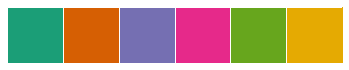

In [224]:
color_palette = sns.color_palette('Dark2')
sns.palplot(color_palette)
sns.set_style('white')
sns.set_context('notebook', font_scale=2)

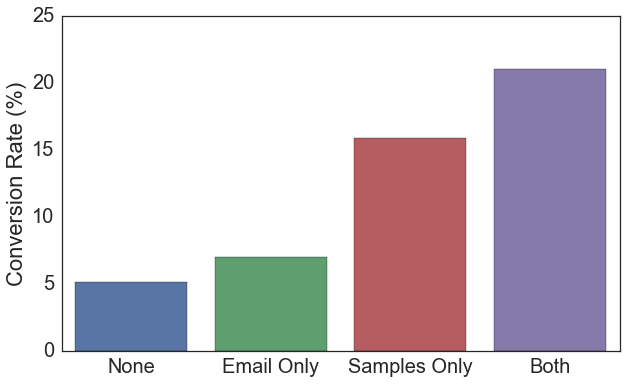

In [237]:
fig = plt.figure()
fig.set_size_inches(10, 6)
sns.barplot(x = 'label', y = 'conversion_rate', data = tidy_xt);
plt.xlabel('');
plt.ylabel('Conversion Rate (%)');

## Purchases by type

In [240]:
xt_species = pd.crosstab(df_all['common_name'], df_all['converted']).reset_index()
xt_species.columns = ['species', 'no_purchase', 'purchase']
xt_species['conversion_rate'] = xt_species['purchase'] / (xt_species['purchase'] + xt_species['no_purchase']) * 100
xt_species

,species,no_purchase,purchase,conversion_rate
0,Amendoim,715,81,10.175879
1,Brazilian Cherry,8438,572,6.348502
2,Brazilian Teak,2606,255,8.912967
3,Brazilian Walnut,2362,147,5.858908
4,Other,536,27,4.795737
5,Patagonian Rosewood,478,47,8.952381
6,Santos Mahogany,2259,197,8.021173
7,Tiete Rosewood,628,93,12.898752
8,Tigerwood,2106,126,5.645161


In [269]:
from pylab import rcParams
rcParams['figure.figsize'] = 8,6

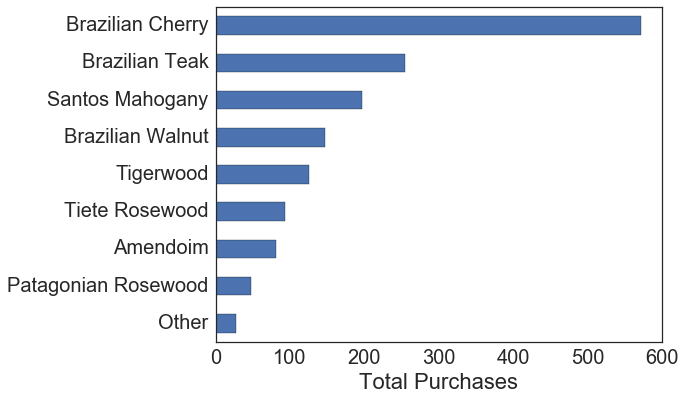

In [270]:
ax = xt_species.sort_values(by='purchase', ascending=True).plot.barh(x='species', y='purchase', legend=False);
plt.ylabel('');
plt.xlabel('Total Purchases');


In [249]:
# all time conversion rate
np.mean(df['converted'].values)

0.068360418097199976

In [257]:
# percent of brazilian cherry
572.0/sum(xt_species['purchase'].values)

0.37022653721682847

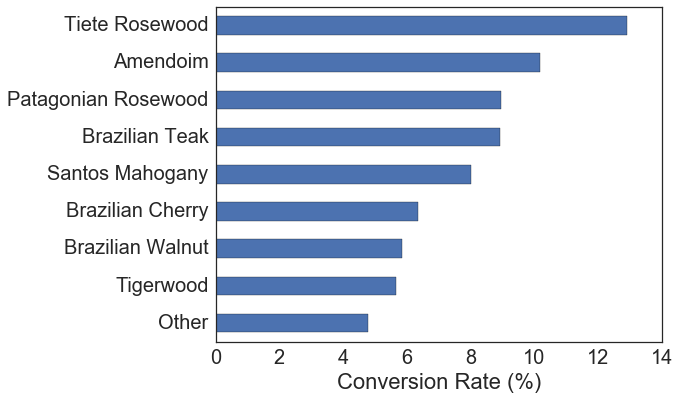

In [272]:
ax = xt_species.sort_values(by='conversion_rate', ascending=True).plot.barh(x='species', y='conversion_rate', legend=False);
plt.ylabel('');
plt.xlabel('Conversion Rate (%)');

In [273]:
pd.crosstab(df_all['converted'], df_all['construction'])

construction,Engineered,Missing,Solid
converted,,,
0,1770,300,18058
1,96,15,1434


In [275]:
96.0/(96+1770)

0.05144694533762058

In [276]:
1434./(1434+18058)

0.07356864354607018

In [307]:
from statsmodels.stats import proportion

In [282]:
def xt_converted(column, df):
    xt = pd.crosstab(df[column], df['converted']).reset_index()
    xt.columns = [column, 'no_purchase', 'purchase']
    xt['total'] = xt['no_purchase'] + xt['purchase']
    xt['conversion_rate'] = xt['purchase'] / xt['total'] * 100
    return xt

In [308]:
xt_finish = xt_converted('finish', df_all)
xt_finish

,finish,no_purchase,purchase,total,conversion_rate
0,Missing,379,16,395,4.050633
1,Prefinished,15800,1174,16974,6.916460
2,Unfinished,3949,355,4304,8.248141


In [321]:
proportion.proportions_chisquare([1174, 355], [16974, 4304])[1]

0.0025155527736590213

In [284]:
xt_converted('construction', df_all)

,construction,no_purchase,purchase,total,conversion_rate
0,Engineered,1770,96,1866,5.144695
1,Missing,300,15,315,4.761905
2,Solid,18058,1434,19492,7.356864


In [322]:
proportion.proportions_chisquare([96, 1434], [1866, 19492])[1]

0.00040019694984658037

In [288]:
xt_converted('phone_provided', df_all)

,phone_provided,no_purchase,purchase,total,conversion_rate
0,0,12953,660,13613,4.848307
1,1,7175,885,8060,10.980149


In [323]:
proportion.proportions_chisquare([660, 885], [13613, 8060])[1]

1.7297762723674187e-64

In [290]:
xt_converted('sq_ft_bin', df_all)

,sq_ft_bin,no_purchase,purchase,total,conversion_rate
0,0-500,3820,325,4145,7.840772
1,1001-1500,3921,330,4251,7.762879
2,1501-2000,2151,157,2308,6.802426
3,2001-5000,2059,172,2231,7.709547
4,5001+,228,9,237,3.797468
5,501-1000,7947,551,8498,6.483879


In [292]:
xt_converted('milling', df_all)

,milling,no_purchase,purchase,total,conversion_rate
0,Micro Bevel 4 Sides,15741,1171,16912,6.924078
1,Missing,704,32,736,4.347826
2,Square Edges,3683,342,4025,8.496894


In [325]:
proportion.proportions_chisquare([1171, 342], [16912, 4025])[1]

0.00053300993751817787

In [293]:
xt_converted('width', df_all)

,width,no_purchase,purchase,total,conversion_rate
0,3,3049,242,3291,7.353388
1,3 1/4,6980,513,7493,6.846390
2,4,2988,271,3259,8.315434
3,4 3/4,1208,55,1263,4.354711
4,5,4864,424,5288,8.018154
5,Other,1039,40,1079,3.707136


In [326]:
# 3 vs 4
proportion.proportions_chisquare([242, 271], [3291, 3259])[1]

0.14735153744966914

In [327]:
# 3 vs 5
proportion.proportions_chisquare([242, 424], [3291, 5288])[1]

0.26318498900029796

In [328]:
# 4 vs 3 1/4
proportion.proportions_chisquare([513, 271], [7493, 3259])[1]

0.0070876636062558798

In [329]:
# 5 vs 3 1/4
proportion.proportions_chisquare([513, 424], [7493, 5288])[1]

0.012311257462911217

In [330]:
xt_converted('employee_id', df_all)

,employee_id,no_purchase,purchase,total,conversion_rate
0,DC,4276,331,4607,7.184719
1,NP,5864,486,6350,7.653543
2,OTHER,1904,65,1969,3.301168
3,SO,8084,663,8747,7.579742


In [331]:
proportion.proportions_chisquare([331, 663], [4607, 8747])[1]

0.40838978420347005

In [285]:
df_all.columns

Index([u'quote_id', u'email', u'date_created', u'days_until_needed',
       u'phone_provided', u'ship_state', u'install_subfloor', u'employee_id',
       u'sq_ft', u'cust_price', u'retail_price', u'common_name', u'finish',
       u'grade', u'milling', u'width', u'construction',
       u'days_until_needed_bin', u'sq_ft_bin', u'converted', u'month', u'year',
       u'mail_chimp', u'samples'],
      dtype='object')

In [340]:
xt_converted('days_until_needed_bin', df_all)

,days_until_needed_bin,no_purchase,purchase,total,conversion_rate
0,0-30,2647,155,2802,5.531763
1,31-60,3991,273,4264,6.402439
2,61-90,630,68,698,9.742120
3,91+,2764,173,2937,5.890364


In [341]:
proportion.proportions_chisquare([273, 155], [4264, 2802])[1]

0.13338698334365676

In [342]:
proportion.proportions_chisquare([68, 155],[698, 2802])[1]

4.6020863272119286e-05

In [357]:
# create grouping for states
# http://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
state_divisions = {}
pacific = ['WA', 'OR', 'CA', 'AK', 'HI']
mountain = ['MT', 'ID', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM']
west_north_central = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']
west_south_central = ['TX', 'OK', 'AR', 'LA']
east_north_central = ['WI', 'MI', 'IL', 'IN', 'OH']
east_south_central = ['KY', 'TN', 'MS', 'AL']
south_atlantic = ['FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'MD', 'DE', 'DC']
middle_atlantic = ['NY', 'PA', 'NJ']
new_england = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

state_regions = {}
west = pacific + mountain
midwest = west_north_central + east_north_central
south = west_south_central + east_south_central + south_atlantic
northeast = middle_atlantic + new_england

In [358]:
def state_dict(the_dict, the_list, region):
    for state in the_list:
        the_dict[state] = region

In [359]:
# create divisions dict
state_divisions = state_dict(state_divisions, pacific, 'pacific')
state_divisions = state_dict(state_divisions, mountain, 'mountain')
state_divisions = state_dict(state_divisions, west_north_central, 'west_north_central')
state_divisions = state_dict(state_divisions, west_south_central, 'west_south_central')
state_divisions = state_dict(state_divisions, east_north_central, 'east_north_central')
state_divisions = state_dict(state_divisions, east_south_central, 'east_south_central')
state_divisions = state_dict(state_divisions, south_atlantic, 'south_atlantic')
state_divisions = state_dict(state_divisions, middle_atlantic, 'middle_atlantic')
state_divisions = state_dict(state_divisions, new_england, 'new_england')

# create regions dict
state_regions = state_dict(state_regions, west, 'west')
state_regions = state_dict(state_regions, midwest, 'midwest')
state_regions = state_dict(state_regions, south, 'south')
state_regions = state_dict(state_regions, northeast, 'northeast')

In [360]:
df_all['state_division'] = [state_divisions[x] if x in state_divisions else 'Other' for x in df_all['ship_state']]

In [361]:
df_all['state_region'] = [state_regions[x] if x in state_regions else 'Other' for x in df_all['ship_state']]

In [362]:
xt_converted('state_region', df_all)

,state_region,no_purchase,purchase,total,conversion_rate
0,Other,779,9,788,1.142132
1,midwest,3699,279,3978,7.013575
2,northeast,5528,555,6083,9.123788
3,south,5978,438,6416,6.826683
4,west,4144,264,4408,5.989111


In [363]:
proportion.proportions_chisquare([555, 279], [6083, 3978])[1]

0.00017445202704928766

In [364]:
proportion.proportions_chisquare([555, 438], [6083, 6416])[1]

2.0697630612539759e-06

In [365]:
proportion.proportions_chisquare([555, 264], [6083, 4408])[1]

3.4799539322200921e-09

In [366]:
df_all.columns

Index([u'quote_id', u'email', u'date_created', u'days_until_needed',
       u'phone_provided', u'ship_state', u'install_subfloor', u'employee_id',
       u'sq_ft', u'cust_price', u'retail_price', u'common_name', u'finish',
       u'grade', u'milling', u'width', u'construction',
       u'days_until_needed_bin', u'sq_ft_bin', u'converted', u'month', u'year',
       u'mail_chimp', u'samples', u'state_division', u'state_region'],
      dtype='object')

In [367]:
xt_converted('phone_provided', df_all)

,phone_provided,no_purchase,purchase,total,conversion_rate
0,0,12953,660,13613,4.848307
1,1,7175,885,8060,10.980149


In [368]:
xt_converted('grade', df_all)

,grade,no_purchase,purchase,total,conversion_rate
0,Clear,16655,1247,17902,6.965702
1,Missing,513,50,563,8.880995
2,Premium/A,1643,119,1762,6.753689
3,Select & Better,1317,129,1446,8.921162


In [369]:
xt_converted('state_division', df_all)

,state_division,no_purchase,purchase,total,conversion_rate
0,Other,779,9,788,1.142132
1,east_north_central,2866,220,3086,7.128970
2,east_south_central,713,61,774,7.881137
3,middle_atlantic,4301,450,4751,9.471690
4,mountain,816,60,876,6.849315
5,new_england,1227,105,1332,7.882883
6,pacific,3328,204,3532,5.775764
7,south_atlantic,4198,322,4520,7.123894
8,west_north_central,833,59,892,6.614350
9,west_south_central,1067,55,1122,4.901961


In [372]:
pd.DataFrame({'sq_ft' : df['sq_ft'].values % 10})['sq_ft'].value_counts()

0.00    35691
5.00     1344
7.00      929
2.00      246
8.00      242
4.00      231
6.00      219
1.00      159
9.00      130
3.00      122
5.25        1
2.70        1
7.80        1
0.37        1
2.56        1
5.50        1
9.80        1
7.40        1
Name: sq_ft, dtype: int64

In [373]:
df.shape

(39321, 22)

In [374]:
df.loc[df['sq_ft']%10 != 7, :].shape

(38392, 22)